In [ ]:
!git clone https://github.com/grimmdaniel/personality-trait-prediction.git

Cloning into 'personality-trait-prediction'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10 (delta 0), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 747.36 KiB | 5.62 MiB/s, done.


In [ ]:
!cd personality-trait-prediction/

In [ ]:
!pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=54e35ec618d09c2adf08ca2f2e3fd3a46b96ab520181f0b2b5b0ed33c35af4ed
  Stored in directory: /root/.cache/pip/wheels/56/30/c5/576bdd729f3bc062d62a551be7fefd6ed2f761901568171e4e
Successfully built ffmpeg


In [ ]:
!pip install ffmpeg-python

In [ ]:
!unzip /content/file.zip


Archive:  /content/file.zip


In [ ]:
!unzip /content/ChaLearn2016_tiny.zip


Archive:  /content/ChaLearn2016_tiny.zip
   creating: ChaLearn2016_tiny/
  inflating: __MACOSX/._ChaLearn2016_tiny  
   creating: ChaLearn2016_tiny/valid/
  inflating: __MACOSX/ChaLearn2016_tiny/._valid  
   creating: ChaLearn2016_tiny/test/
  inflating: __MACOSX/ChaLearn2016_tiny/._test  
   creating: ChaLearn2016_tiny/annotation/
  inflating: __MACOSX/ChaLearn2016_tiny/._annotation  
   creating: ChaLearn2016_tiny/train/
  inflating: __MACOSX/ChaLearn2016_tiny/._train  
  inflating: ChaLearn2016_tiny/valid/HhC2cGFFZeY.002.mp4  
  inflating: __MACOSX/ChaLearn2016_tiny/valid/._HhC2cGFFZeY.002.mp4  
  inflating: ChaLearn2016_tiny/valid/XhgDsQlEnuU.005.mp4  
  inflating: __MACOSX/ChaLearn2016_tiny/valid/._XhgDsQlEnuU.005.mp4  
  inflating: ChaLearn2016_tiny/valid/jFx6AEw6viQ.000.mp4  
  inflating: __MACOSX/ChaLearn2016_tiny/valid/._jFx6AEw6viQ.000.mp4  
  inflating: ChaLearn2016_tiny/valid/m7zdWVDT-34.000.mp4  
  inflating: __MACOSX/ChaLearn2016_tiny/valid/._m7zdWVDT-34.000.mp4  
  infla

In [ ]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import ffmpeg as ff
import os
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import random
import cv2
import pickle
import datetime

In [ ]:
def extract_audio_from_video(file_path: str) -> np.ndarray:
    inputfile = ff.input(file_path)
    out = inputfile.output('-', format='f32le', acodec='pcm_f32le', ac=1, ar='44100')
    raw = out.run(capture_stdout=True)
    del inputfile, out
    return np.frombuffer(raw[0],np.float32)

def preprocess_audio_series(raw_data: np.ndarray) -> np.ndarray:
    N, M = 24, 1319
    mfcc_data = librosa.feature.mfcc(y = raw_data, n_mfcc= 24)

    #Getting spectral mean (centroid)
    #mean = librosa.feature.spectral_centroid(result)

    #Standardizing MFCC (zero mean and unit variance)
    mfcc_data_standardized = (mfcc_data - np.mean(mfcc_data)) / np.std(mfcc_data)

    # Use pre-padding (Note: with 0, which is also the mean after standardization) to unify the length of the samples.
    number_of_columns_to_fill = M - mfcc_data_standardized.shape[1]
    padding = np.zeros((N,number_of_columns_to_fill))

    padded_data = np.hstack((padding, mfcc_data_standardized))

    #Reshaping to N,M,1
    return padded_data.reshape(N,M,1)

def preprocess_audio_series_segments(raw_data: np.ndarray, num_segments: int = 5) -> np.ndarray:
    N, M = 24, 1319  # MFCC dimensions
    segment_length = len(raw_data) // num_segments  # Divide audio into segments

    # Create an empty list to store processed segments
    all_segments = []

    # Loop over the segments and process each
    for i in range(num_segments):
        # Extract segment
        start_idx = i * segment_length
        end_idx = (i + 1) * segment_length if (i + 1) * segment_length < len(raw_data) else len(raw_data)
        segment = raw_data[start_idx:end_idx]

        # Extract MFCC from the segment
        mfcc_data = librosa.feature.mfcc(y=segment, n_mfcc=24)

        # Standardize MFCC (zero mean and unit variance)
        mfcc_data_standardized = (mfcc_data - np.mean(mfcc_data)) / np.std(mfcc_data)

        # Padding to ensure the MFCC matrix has consistent size (M columns)
        number_of_columns_to_fill = M - mfcc_data_standardized.shape[1]
        padding = np.zeros((N, number_of_columns_to_fill))
        padded_data = np.hstack((padding, mfcc_data_standardized))

        # Reshaping to N, M, 1
        all_segments.append(padded_data.reshape(N, M, 1))

    # Stack all segments along a new dimension (e.g., for batch processing)
    return np.stack(all_segments, axis=0)  # Shape will be (num_segments, N, M, 1)

def get_number_of_frames(file_path: str) -> int:
    probe = ff.probe(filePath)
    video_streams = [stream for stream in probe["streams"] if stream["codec_type"] == "video"]
    #width = video_streams[0]['coded_width']
    #height = video_streams[0]['coded_height']
    del probe
    return video_streams[0]['nb_frames']

def extract_N_video_frames(file_path: str, number_of_samples: int = 5) -> List[np.ndarray]:
    nb_frames = int(get_number_of_frames(file_path= filePath))

    video_frames = []
    # random_indexes = random.sample(range(0, nb_frames), number_of_samples)
    frame_indices = np.linspace(0, nb_frames - 1, number_of_samples, dtype=int)
    print("num frames = ", nb_frames, "frame indices = ", frame_indices)

    cap = cv2.VideoCapture(filePath)
    for ind in frame_indices:
        # cap.set(1,ind)
        cap.set(cv2.CAP_PROP_POS_FRAMES, ind)
        res, frame = cap.read()
        video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    # del cap, random_indexes
    del cap
    return video_frames

def resize_image(image: np.ndarray, new_size: Tuple[int,int]) -> np.ndarray:
    return cv2.resize(image, new_size, interpolation = cv2.INTER_AREA)

def crop_image_window(image: np.ndarray, training: bool = True) -> np.ndarray:
    height, width, _ = image.shape
    if training:
        MAX_N = height - 128
        MAX_M = width - 128
        rand_N_index, rand_M_index = random.randint(0, MAX_N) , random.randint(0, MAX_M)
        return image[rand_N_index:(rand_N_index+128),rand_M_index:(rand_M_index+128),:]
    else:
        N_index = (height - 128) // 2
        M_index = (width - 128) // 2
        return image[N_index:(N_index+128),M_index:(M_index+128),:]

def reading_label_data(file_name: str, dictionary: Dict[str,str]) -> np.ndarray:
    features = ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
    extracted_data = [float(dictionary[label][file_name]) for label in features]
    return np.stack(extracted_data).reshape(5,1)

def preprocessing_input(file_path: str, file_name: str, dictionary: Dict[str,str], training: bool = True) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    #Audio
    extracted_audio_raw = extract_audio_from_video(file_path= filePath)
    preprocessed_audio = preprocess_audio_series_segments(raw_data= extracted_audio_raw)
    print(preprocessed_audio.shape)

    #Video
    sampled = extract_N_video_frames(file_path= filePath, number_of_samples= 5)
    resized_images = [resize_image(image= im, new_size= (248,140)) for im in sampled]
    cropped_images = [crop_image_window(image= resi,training= training) / 255.0 for resi in resized_images]
    preprocessed_video = np.stack(cropped_images)

    #Ground Truth
    video_gt = reading_label_data(file_name= file_name, dictionary= dictionary)
    del extracted_audio_raw, sampled, resized_images, cropped_images
    return (preprocessed_audio, preprocessed_video, video_gt)

In [ ]:
training_set_data = []
path = '/content/ChaLearn2016_tiny/train'
gt = pickle.load( open( "/content/ChaLearn2016_tiny/annotation/annotation_training.pkl", "rb" ), encoding='latin1' )
t1 = datetime.datetime.utcnow()
for filename in os.listdir(path):
    filePath = path+'/'+filename
    print(filename)
    training_set_data.append(preprocessing_input(file_path= filePath, file_name= filename, dictionary= gt, training= True))
    # break
t2 = datetime.datetime.utcnow()
#Measuring execution time
print('Elapsed time: ' + str(t2-t1))

KJ643kfjqLY.003.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
Uu-NbXUPr-A.001.mp4
(5, 24, 1319, 1)
num frames =  383 frame indices =  [  0  95 191 286 382]
Qz_cjgCtDcM.003.mp4
(5, 24, 1319, 1)
num frames =  383 frame indices =  [  0  95 191 286 382]
vrMlwwTLWIE.005.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
_uNup91ZYw0.002.mp4
(5, 24, 1319, 1)
num frames =  367 frame indices =  [  0  91 183 274 366]
L9sG80PI1Gw.003.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
NDBCrVvp0Vg.003.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
eD4b8sM-Tpw.000.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
50gokPvvMs8.000.mp4
(5, 24, 1319, 1)
num frames =  367 frame indices =  [  0  91 183 274 366]
W0FCCk0a0tg.001.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
yOzHZOg95Ug.003.mp4
(5, 24, 1319, 1)
num frames =  449 frame

In [ ]:
savename = 'training_set_aud_vis.dat'
with open(savename, "wb") as f:
    pickle.dump(training_set_data, f)

In [ ]:
validation_set_data = []
path = '/content/ChaLearn2016_tiny/valid'
gt = pickle.load( open( "/content/ChaLearn2016_tiny/annotation/annotation_validation.pkl", "rb" ), encoding='latin1' )
t1 = datetime.datetime.utcnow()
for filename in os.listdir(path):
    filePath = path+'/'+filename
    print(filename)
    validation_set_data.append(preprocessing_input(file_path= filePath, file_name= filename, dictionary= gt, training= False))
t2 = datetime.datetime.utcnow()
#Measuring execution time
print('Elapsed time: ' + str(t2-t1))

VxtZDXM0cuQ.004.mp4
(5, 24, 1319, 1)
num frames =  255 frame indices =  [  0  63 127 190 254]
jFx6AEw6viQ.000.mp4
(5, 24, 1319, 1)
num frames =  220 frame indices =  [  0  54 109 164 219]
SgWtBK48AjE.000.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
_fJcW5234bY.001.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
m_9aygJNij8.000.mp4
(5, 24, 1319, 1)
num frames =  458 frame indices =  [  0 114 228 342 457]
nUbhRInpVbA.002.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
05l5bteT_qA.004.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
HhC2cGFFZeY.002.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
RCr48dXuZYE.003.mp4
(5, 24, 1319, 1)
num frames =  383 frame indices =  [  0  95 191 286 382]
VJuVsi6G96s.005.mp4
(5, 24, 1319, 1)
num frames =  367 frame indices =  [  0  91 183 274 366]
m7zdWVDT-34.000.mp4
(5, 24, 1319, 1)
num frames =  383 frame

In [ ]:
savename = 'validation_set_aud_vis.dat'
with open(savename, "wb") as f:
    pickle.dump(validation_set_data, f)

In [ ]:
test_set_data = []
path = '/content/ChaLearn2016_tiny/test'
gt = pickle.load( open( "/content/ChaLearn2016_tiny/annotation/annotation_test.pkl", "rb" ), encoding='latin1' )
t1 = datetime.datetime.utcnow()
for filename in os.listdir(path):
    filePath = path+'/'+filename
    print(filename)
    test_set_data.append(preprocessing_input(file_path= filePath, file_name= filename, dictionary= gt, training= False))
t2 = datetime.datetime.utcnow()
#Measuring execution time
print('Elapsed time: ' + str(t2-t1))

2fzLibPAtvI.003.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
3b9fhd-EDaY.000.mp4
(5, 24, 1319, 1)
num frames =  383 frame indices =  [  0  95 191 286 382]
0iQIfGnKflc.003.mp4
(5, 24, 1319, 1)
num frames =  367 frame indices =  [  0  91 183 274 366]
_0bg1TLPP-I.000.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
-4J4xkfN5cI.000.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
4fN-DKUzgWQ.004.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
4XdZDodpzac.004.mp4
(5, 24, 1319, 1)
num frames =  232 frame indices =  [  0  57 115 173 231]
2mfmw63l88g.000.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
4RKQGZzPClk.000.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
1q-N_zbsAg0.005.mp4
(5, 24, 1319, 1)
num frames =  459 frame indices =  [  0 114 229 343 458]
3Vr5-zedeWk.001.mp4
(5, 24, 1319, 1)
num frames =  459 frame

In [ ]:
savename = 'test_set_aud_vis.dat'
with open(savename, "wb") as f:
    pickle.dump(test_set_data, f)

In [ ]:
with open('training_set_aud_vis.dat', "rb") as training_file:
    train_set_data = pickle.load(training_file)

with open('validation_set_aud_vis.dat', "rb") as validation_file:
    validation_set_data = pickle.load(validation_file)

with open('test_set_aud_vis.dat', "rb") as test_file:
    test_set_data = pickle.load(test_file)

In [ ]:
# train_set_data[0][0]

<Axes: ylabel='Density'>

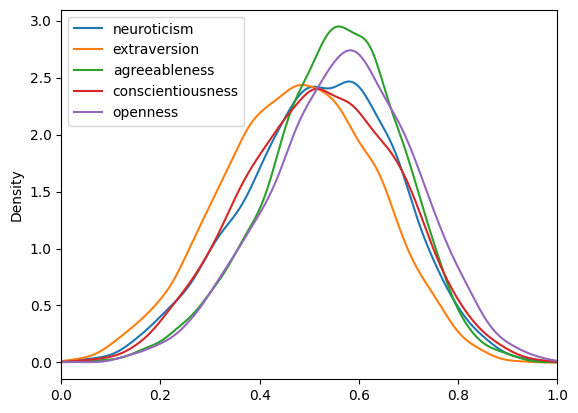

In [ ]:
gt = pickle.load( open( "/content/ChaLearn2016_tiny/annotation/annotation_training.pkl", "rb" ), encoding='latin1' )
neuroticism = list(gt['neuroticism'].values())
extraversion = list(gt['extraversion'].values())
agreeableness = list(gt['agreeableness'].values())
conscientiousness = list(gt['conscientiousness'].values())
openness = list(gt['openness'].values())

df = pd.DataFrame({'neuroticism': neuroticism,'extraversion': extraversion,'agreeableness':agreeableness,'conscientiousness':conscientiousness,'openness':openness})
df.plot(kind='density',xlim=(0,1))

In [ ]:
print(len(train_set_data))
print(len(validation_set_data))
print(len(test_set_data))

60
20
20


In [ ]:
train_random_index = random.randint(0, len(train_set_data)-1)
validation_random_index = random.randint(0, len(validation_set_data)-1)
test_random_index = random.randint(0, len(test_set_data)-1)

In [ ]:
train_set_data[train_random_index][0].shape

(5, 24, 1319, 1)

In [ ]:
# shape = train_set_data[train_random_index][0].shape
# print(shape)
# mfcc_train = train_set_data[train_random_index][0].reshape(shape[0],shape[1])

# shape = validation_set_data[validation_random_index][0].shape
# mfcc_validation = validation_set_data[validation_random_index][0].reshape(shape[0],shape[1])

# shape = test_set_data[test_random_index][0].shape
# mfcc_train = test_set_data[test_random_index][0].reshape(shape[0],shape[1])

# mfccs = [mfcc_train,mfcc_validation,mfcc_train]

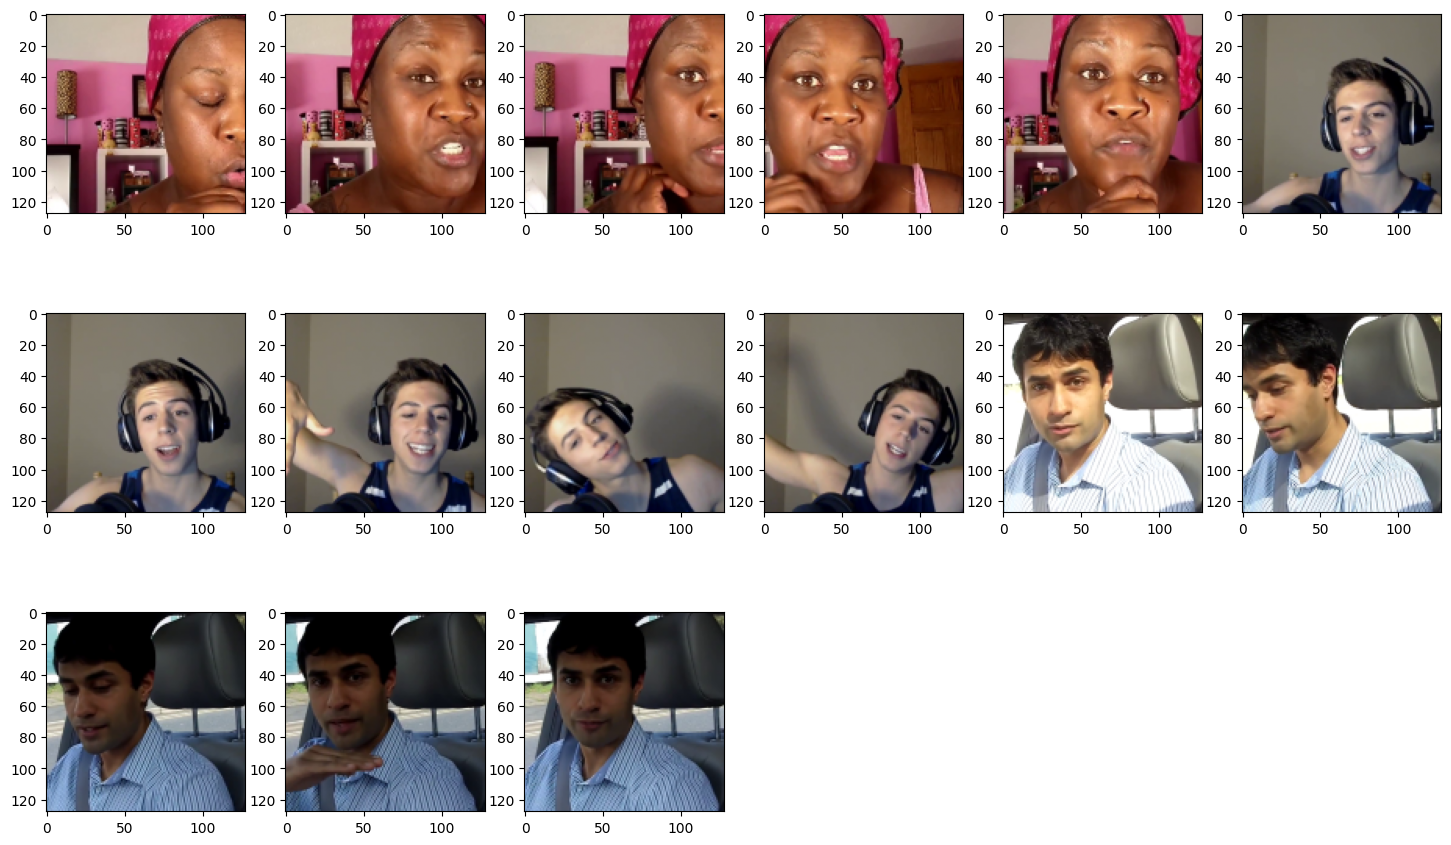

In [ ]:
images_to_plot = []
images_to_plot.extend([(train_set_data[train_random_index][1])[i,:,:,:] for i in range(0,5)])
images_to_plot.extend([(validation_set_data[validation_random_index][1])[i,:,:,:] for i in range(0,5)])
images_to_plot.extend([(test_set_data[test_random_index][1])[i,:,:,:] for i in range(0,5)])


plt.figure(figsize=(18,11))

for i in range(15):
    plt.subplot(3,6,i+1)
    plt.imshow(images_to_plot[i])
plt.show()

In [ ]:
def reshape_to_expected_input(dataset: List[Tuple[np.ndarray,np.ndarray,np.ndarray]]) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    x0_list = []
    x1_list = []
    y_list = []
    for i in range(0,len(dataset)):
        x0_list.append(dataset[i][0])
        x1_list.append(dataset[i][1])
        y_list.append(dataset[i][2])
    return (np.stack(x0_list),np.stack(x1_list),np.stack(y_list))

In [ ]:
train_input = reshape_to_expected_input(dataset= train_set_data)
# del train_set_data
validation_input = reshape_to_expected_input(dataset= validation_set_data)
# del validation_set_data
test_input = reshape_to_expected_input(dataset= test_set_data)
# del test_set_data

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, LSTM, Bidirectional, Lambda, Dropout, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import TimeDistributed

In [ ]:

# audio_model = Conv2D(32, kernel_size=(3,3),activation='relu')(audio_input)
# audio_model = BatchNormalization()(audio_model)
# audio_model = MaxPooling2D(pool_size=(2, 2))(audio_model)
# audio_model = Conv2D(32, kernel_size=(3,3),activation='relu')(audio_model)
# audio_model = BatchNormalization()(audio_model)
# audio_model = MaxPooling2D(pool_size=(2, 2))(audio_model)
# audio_model = Flatten()(audio_model)
# audio_model = Dense(128, activation='relu')(audio_model)
# audio_subnetwork = Model(inputs=audio_input,outputs=audio_model)

In [ ]:

def create_audio_cnn():
    audio_model = Input(shape=(24, 1319, 1))
    x = Conv2D(32, kernel_size=(3,3), activation='relu')(audio_model)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(32, kernel_size=(3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)  # Output a feature vector of size 128
    return Model(inputs=audio_model, outputs=x)


In [ ]:
audio_input = Input(shape=(5, 24,1319,1))

In [ ]:
cnn = create_audio_cnn()

In [ ]:
encoded_segment = TimeDistributed(cnn)(audio_input)  # Shape: (batch_size, num_segments, 128)

In [ ]:
encoded_audio = LSTM(64)(encoded_segment)

In [ ]:
audio_subnetwork = Model(inputs=audio_input, outputs=encoded_audio)

In [ ]:
from keras.applications import vgg16
import timm
import torch

vit_model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
# vit_model.head = tf.keras.layers.Identity()  # Remove classification head

# Define the input shape
visual_model = Input(shape=(5, 128, 128, 3))

# Wrap ViT inside a Lambda layer for feature extraction
# def vit_feature_extractor(x):
#     x = tf.image.resize(x, (224, 224))  # Resize input to ViT's expected size
#     return vit_model(x)
def vit_feature_extractor(x):
    x = tf.image.resize(x, (224, 224))  # Resize input to ViT's expected size
    return vit_model(x)

# def vit_feature_extractor(image_batch):
#     with torch.no_grad():
#         features = model(image_batch)  # Extract features
#     return features.cpu().numpy()

encoded_frame = TimeDistributed(Lambda(vit_feature_extractor, output_shape=(512,)))(visual_model)
# encoded_frame = TimeDistributed(Lambda(lambda x: cnn(x)))(visual_model)
encoded_vid = LSTM(64)(encoded_frame)
visual_subnetwork = Model(inputs= visual_model,outputs=encoded_vid)

In [ ]:
# from keras.applications import vgg16
# import timm
# import torch

# vit_model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
# # vit_model.head = tf.keras.layers.Identity()  # Remove classification head

# # Define the input shape
# visual_model = Input(shape=(5, 128, 128, 3))

# # Wrap ViT inside a Lambda layer for feature extraction
# # def vit_feature_extractor(x):
# #     x = tf.image.resize(x, (224, 224))  # Resize input to ViT's expected size
# #     return vit_model(x)

# def vit_feature_extractor(image_batch):
#     with torch.no_grad():
#         features = visual_model(image_batch)  # Extract features
#     return features.cpu().numpy()

# # vit = timm.create_model("vit_base_patch16_224", pretrained=True)
# # vit.head = torch.nn.Identity()  # Remove the classification head

# # # Function to extract ViT features
# # def vit_feature_extractor(x):
# #     x = torch.tensor(x.numpy()).permute(0, 3, 1, 2)  # Convert to (batch, channels, height, width)
# #     with torch.no_grad():
# #         features = vit(x)  # Extract features
# #     return tf.convert_to_tensor(features.numpy())

# # # Define video input (5 frames of 128x128 RGB images)
# # visual_model = Input(shape=(5, 128, 128, 3))

# # # Apply ViT in a TimeDistributed manner
# # encoded_frame = TimeDistributed(Lambda(vit_feature_extractor ,output_shape=(768,)))(visual_model)

# # # Pass extracted features through LSTM
# # encoded_vid = LSTM(64)(encoded_frame)

# # # Define the visual subnetwork
# # visual_subnetwork = Model(inputs=visual_model, outputs=encoded_vid)


# # model = timm.create_model('vit_base_patch16_224', pretrained=True)
# # model.head = torch.nn.Identity()  # Remove classification head
# # model.eval()

# # def extract_vit_features(image_batch):
# #     with torch.no_grad():
# #         features = model(image_batch)  # Extract features
# #     return features.cpu().numpy()

# encoded_frame = TimeDistributed(Lambda(vit_feature_extractor,output_shape=(768,)))(visual_model)
# # encoded_frame = TimeDistributed(Lambda(lambda x: cnn(x)))(visual_model)
# encoded_vid = LSTM(64)(encoded_frame)



# # cnn = vgg16.VGG16(weights="imagenet", include_top=False, pooling='max') #try using ViT here using timm
# # cnn.trainable = False
# # encoded_frame = TimeDistributed(Lambda(lambda x: cnn(x)))(visual_model)
# # encoded_vid = LSTM(64)(encoded_frame)

# visual_subnetwork = Model(inputs= visual_model,outputs=encoded_vid)


In [ ]:
from keras.applications import vgg16

visual_model = Input(shape=(5,128,128,3))

cnn = vgg16.VGG16(weights="imagenet", include_top=False, pooling='max') #try using ViT here using timm
cnn.trainable = False
encoded_frame = TimeDistributed(Lambda(lambda x: cnn(x)))(visual_model)
encoded_vid = LSTM(64)(encoded_frame)

visual_subnetwork = Model(inputs=visual_model,outputs=encoded_vid)


In [ ]:
combined = Concatenate()([audio_subnetwork.output, visual_subnetwork.output])
final1 = Dense(256, activation='relu')(combined)
final2 = Dense(5, activation='linear')(final1)

In [ ]:
combined_network = Model(inputs=[audio_input, visual_model], outputs=final2)
combined_network.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 5, 24, 1319, 1) │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_24            │ (None, 5, 128, 128, 3) │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 5, 128)         │      5,383,904 │ input_layer_4[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_21       │ (None, 5, 768)         │              0 │ input_layer_24[0][0]   │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 64)             │         49,408 │ time_distributed_2[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ (None, 64)             │        213,248 │ time_distributed_21[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 128)            │              0 │ lstm_2[0][0],          │
│ (Concatenate)             │                        │                │ lstm_11[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 256)            │         33,024 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_15            │ (None, 5, 24, 1319, 1) │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 5)              │          1,285 │ dense_17[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,680,869 (21.67 MB)

 Trainable params: 5,680,741 (21.67 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
from sklearn import metrics

def r2_score(y_true, y_pred):
    # print(len(y_true.shape), y_pred.shape)
    if len(y_true.shape)>2:
      y_true = tf.squeeze(y_true, axis=-1)  # Remove extra dimension if it exists
    # y_pred = tf.squeeze(y_pred, axis=-1)
    # ss_res = K.sum(K.square(y_true - y_pred))  # Residual sum of squares
    # ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    # return 1 - (ss_res / (ss_tot + K.epsilon()))  # R² score
    r2 = metrics.r2_score(y_true, y_pred)
    return r2

def ccc(gold, pred):
    if len(gold.shape)>2:
      gold = tf.squeeze(gold, axis=-1)  # Remove extra dimension if it exists
    # gold       = K.squeeze(gold, axis=-1)
    # pred       = K.squeeze(pred, axis=-1)
    gold_mean  = K.mean(gold, axis=-1, keepdims=True)
    pred_mean  = K.mean(pred, axis=-1, keepdims=True)
    covariance = (gold-gold_mean)*(pred-pred_mean)
    gold_var   = K.mean(K.square(gold-gold_mean), axis=-1,  keepdims=True)
    pred_var   = K.mean(K.square(pred-pred_mean), axis=-1, keepdims=True)
    ccc        = K.constant(2.) * covariance / (gold_var + pred_var + K.square(gold_mean - pred_mean) + K.epsilon())
    return ccc

def ccc_loss(gold, pred):
    # input (num_batches, seq_len, 1)
    ccc_loss   = K.constant(1.) - ccc(gold, pred)
    return ccc_loss

In [ ]:
combined_network.compile(optimizer = 'adam',loss = 'mean_absolute_error',metrics=['mae']) #try using mse
# combined_network.compile(optimizer = 'adam',loss=ccc_loss, metrics=['mae', ccc])

In [ ]:
#mse, ccc and r^2 for evaluation (accuracy = 1 - mae )

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=10) #reduce it to 3 or 4
history = combined_network.fit(x = [train_input[0],train_input[1]],
                               y = train_input[2],
                               validation_data = ([validation_input[0],validation_input[1]],validation_input[2]),
                               epochs = 10,
                               verbose = 1,
                               callbacks = [early_stopping])

Epoch 1/10


AssertionError: Exception encountered when calling TimeDistributed.call().

[1mInput width (3) doesn't match model (224).[0m

Arguments received by TimeDistributed.call():
  • inputs=tf.Tensor(shape=(None, 5, 128, 128, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
combined_network.save('audio_vidual_personality_model_lstm_vgg.h5')

# Optionally, if you want to save only the weights:
combined_network.save_weights('audio_vidual_personality_model_lstm_vgg.weights.h5')

In [ ]:
loss, mae = combined_network.evaluate([test_input[0],test_input[1]],test_input[2], verbose=0)

print('Test loss: {}'.format(loss))

Test loss: 0.11996035277843475


In [ ]:
print(1-mae, mae)

0.8800396472215652 0.11996035277843475


In [ ]:
# from tensorflow.keras.models import load_model
# import tensorflow.keras.config as tfconfig
# tfconfig.enable_unsafe_deserialization()
# # Load the model from the .h5 file
# loaded_model = load_model('audio_vidual_personality_model_lstm_vit.h5', safe_mode = False)
# loaded_model.summary()

Loss: 0.11996035277843475


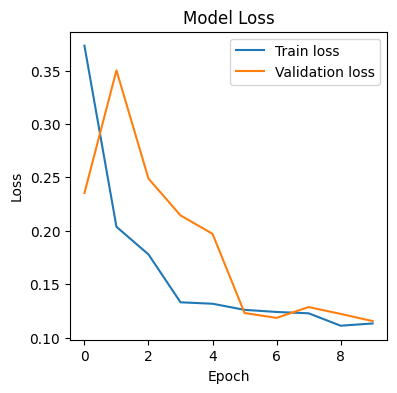

In [ ]:
print('Loss: ' + str(loss))
loss_train = [loss for loss in history.history['loss']]
val_loss = [loss for loss in history.history['val_loss']]
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(loss_train)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')

1-MAE: 0.8800396472215652


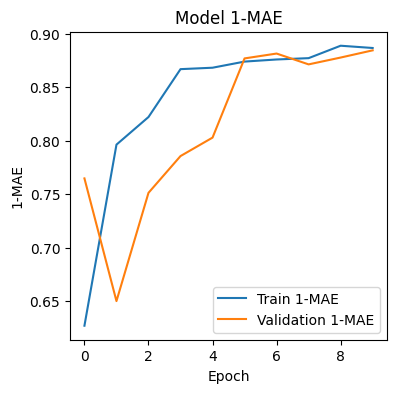

In [ ]:
print('1-MAE: ' + str(1-mae))
one_minus_mae_train = [1-maee for maee in history.history['mae']]
one_minus_mae_val = [1-maee for maee in history.history['val_mae']]
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(one_minus_mae_train)
plt.plot(one_minus_mae_val)
plt.title('Model 1-MAE')
plt.ylabel('1-MAE')
plt.xlabel('Epoch')
plt.legend(['Train 1-MAE', 'Validation 1-MAE'], loc='lower right')

In [ ]:
def compute_ccc(y_true, y_pred):

    mean_y_true = np.mean(y_true, axis=0)
    mean_y_pred = np.mean(y_pred, axis=0)

    var_y_true = np.var(y_true, axis=0)
    var_y_pred = np.var(y_pred, axis=0)

    covariance = np.mean((y_true - mean_y_true) * (y_pred - mean_y_pred), axis=0)

    rho = covariance / (np.sqrt(var_y_true) * np.sqrt(var_y_pred) + 1e-8)  # Pearson Correlation

    ccc = (2 * rho * np.sqrt(var_y_true) * np.sqrt(var_y_pred)) / (var_y_true + var_y_pred + (mean_y_true - mean_y_pred) ** 2)

    return ccc

In [ ]:
gt = test_input[2][:, :, :]
gt = np.squeeze(gt)

In [ ]:
y_pred = combined_network.predict([test_input[0],test_input[1]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


In [ ]:
gt

array([[0.43925234, 0.5625    , 0.52747253, 0.68932039, 0.56666667],
       [0.47663551, 0.57291667, 0.57142857, 0.48543689, 0.45555556],
       [0.52336449, 0.67708333, 0.46153846, 0.59223301, 0.61111111],
       [0.4953271 , 0.64583333, 0.79120879, 0.63106796, 0.54444444],
       [0.57009346, 0.54166667, 0.61538462, 0.36893204, 0.73333333],
       [0.6635514 , 0.60416667, 0.73626374, 0.42718447, 0.6       ],
       [0.4953271 , 0.58333333, 0.72527473, 0.55339806, 0.52222222],
       [0.38317757, 0.38541667, 0.38461538, 0.32038835, 0.5       ],
       [0.69158879, 0.64583333, 0.73626374, 0.55339806, 0.7       ],
       [0.27102804, 0.20833333, 0.40659341, 0.30097087, 0.33333333],
       [0.34579439, 0.4375    , 0.37362637, 0.66019417, 0.41111111],
       [0.44859813, 0.63541667, 0.59340659, 0.59223301, 0.61111111],
       [0.43925234, 0.5       , 0.68131868, 0.5631068 , 0.64444444],
       [0.3364486 , 0.25      , 0.37362637, 0.41747573, 0.62222222],
       [0.36448598, 0.48958333, 0.

In [ ]:
y_pred

array([[0.31618294, 0.60318094, 0.41584876, 0.48233795, 0.5554781 ],
       [0.43626297, 0.5958167 , 0.3841783 , 0.6209731 , 0.5186892 ],
       [0.4493505 , 0.6315039 , 0.47022846, 0.6473557 , 0.56415564],
       [0.4592584 , 0.5364772 , 0.3837601 , 0.5729542 , 0.5054087 ],
       [0.4915529 , 0.5313718 , 0.39870393, 0.54971874, 0.60694647],
       [0.4621536 , 0.5408787 , 0.39512607, 0.6583668 , 0.56862485],
       [0.42176235, 0.48434013, 0.32427683, 0.48841906, 0.47705796],
       [0.46480095, 0.57228726, 0.39514914, 0.54057527, 0.5501113 ],
       [0.40993926, 0.53124565, 0.38747504, 0.54442763, 0.55553454],
       [0.40021467, 0.58426696, 0.401946  , 0.49037585, 0.40602583],
       [0.33216643, 0.61816597, 0.37634006, 0.5027115 , 0.50695986],
       [0.50161153, 0.5590628 , 0.4548199 , 0.6837325 , 0.55893487],
       [0.40131968, 0.55097693, 0.36339036, 0.50612175, 0.41822073],
       [0.54721296, 0.59242064, 0.4316363 , 0.6159096 , 0.5716387 ],
       [0.44224635, 0.63026685, 0.

In [ ]:
y_pred.shape, gt.shape

((20, 5), (20, 5))

In [ ]:
# !pip install torchmetrics

In [ ]:
from torchmetrics.regression import ConcordanceCorrCoef

In [ ]:
import torch
concordance = ConcordanceCorrCoef(num_outputs=5)
x = torch.tensor(gt, dtype=torch.float32).to("cpu")
y = torch.tensor(y_pred, dtype=torch.float32).to("cpu")
concordance(x, y)

tensor([ 0.1425, -0.0953, -0.1031, -0.1082,  0.4075])

In [ ]:

def ccc(x,y):
    ''' Concordance Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    return rhoc

In [ ]:
ccc_value = compute_ccc(gt, y_pred)
print("Concordance Correlation Coefficient (CCC):", ccc_value)

Concordance Correlation Coefficient (CCC): [ 0.14222064 -0.09461629 -0.10046359 -0.10795959  0.40559612]


In [ ]:
# ccc_val = ccc(gt, y_pred)
# print("Concordance Correlation Coefficient (CCC):", ccc_val)

Concordance Correlation Coefficient (CCC): 0.09705355736884175


In [ ]:
from sklearn.metrics import r2_score
# r2_score(gt, y_pred)
r2_scores = [r2_score(gt[:, i], y_pred[:, i]) for i in range(5)]

In [ ]:
r2_scores

[-0.12874781601979435,
 -0.3356812665246858,
 -1.6240518856801347,
 -0.4144818947520834,
 0.2134955794084572]

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


Text(0.5, 0, 'Y_pred_Neuroticism')

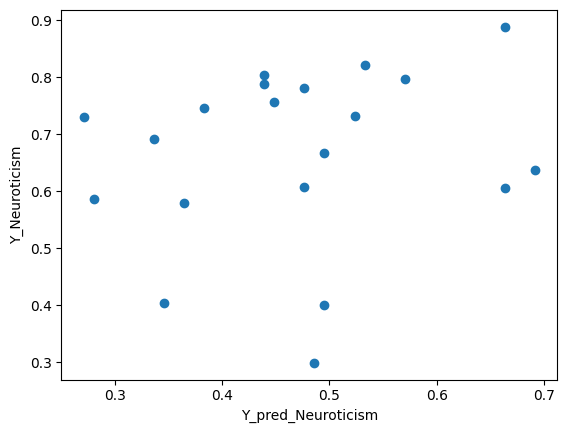

In [ ]:
y_pred = combined_network.predict([test_input[0],test_input[1]])
pred_shape = y_pred.shape
y_pred = y_pred.reshape(pred_shape[0],pred_shape[1],1)
normalized = y_pred / np.max(y_pred)
plt.scatter(test_input[2][:,0,:], normalized[:,0,:], marker='o');
plt.ylabel('Y_Neuroticism')
plt.xlabel('Y_pred_Neuroticism')

In [ ]:
test_input[2][:,0,:]

array([[0.43925234],
       [0.47663551],
       [0.52336449],
       [0.4953271 ],
       [0.57009346],
       [0.6635514 ],
       [0.4953271 ],
       [0.38317757],
       [0.69158879],
       [0.27102804],
       [0.34579439],
       [0.44859813],
       [0.43925234],
       [0.3364486 ],
       [0.36448598],
       [0.47663551],
       [0.28037383],
       [0.53271028],
       [0.6635514 ],
       [0.48598131]])

In [ ]:
history.history

{'loss': [0.3321748971939087,
  0.17526349425315857,
  0.1594504714012146,
  0.12809635698795319,
  0.11794456094503403,
  0.11875138431787491,
  0.10034826397895813,
  0.1020420715212822,
  0.08845057338476181,
  0.0910784900188446],
 'mae': [0.3321748971939087,
  0.17526349425315857,
  0.1594504714012146,
  0.12809635698795319,
  0.11794456094503403,
  0.11875138431787491,
  0.10034826397895813,
  0.1020420715212822,
  0.08845057338476181,
  0.0910784900188446],
 'val_loss': [0.3043319880962372,
  0.4732978940010071,
  0.4556518495082855,
  0.4338168501853943,
  0.34101754426956177,
  0.302595317363739,
  0.20780566334724426,
  0.18476875126361847,
  0.20325255393981934,
  0.17012563347816467],
 'val_mae': [0.3043319880962372,
  0.4732978940010071,
  0.4556518495082855,
  0.4338168501853943,
  0.34101754426956177,
  0.302595317363739,
  0.20780566334724426,
  0.18476875126361847,
  0.20325255393981934,
  0.17012563347816467]}